#### Setup (run before eval)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

nInst = 0
nt = 0
commRate = 0.0010
dlrPosLimit = 10000

In [2]:
def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T

def calcPL(prcHist, getPosition, debug=False):
    (_, nt) = prcHist.shape

    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    for t in range(500, 751):
        prcHistSoFar = prcHist[:, :t]
        newPosOrig = getPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits)
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume

        if debug:
            print(f"Day {t} value: {value:.2f} todayPL: ${todayPL:.2f} $-traded: {totDVolume:.0f} return: {ret:.5f}")

    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd

    return pll, plmu, ret, plstd, annSharpe, totDVolume

In [3]:
pricesFile = "./prices.txt"
prcAll = loadPrices(pricesFile)
print("Loaded %d instruments for %d days" % (nInst, nt))

Loaded 50 instruments for 750 days


#### Strategy

Change the file being imported to run your strategy, e.g.:
```python
from sample import getMyPosition as getPosition
```
to
```python
from clustering import getMyPosition as getPosition
```

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1019.497, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1018.602, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1017.723, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1017.930, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1020.601, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1016.929, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.871 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=525.534, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=520.944, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=522.702, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=522.695, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=519.171, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=523.031, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]         

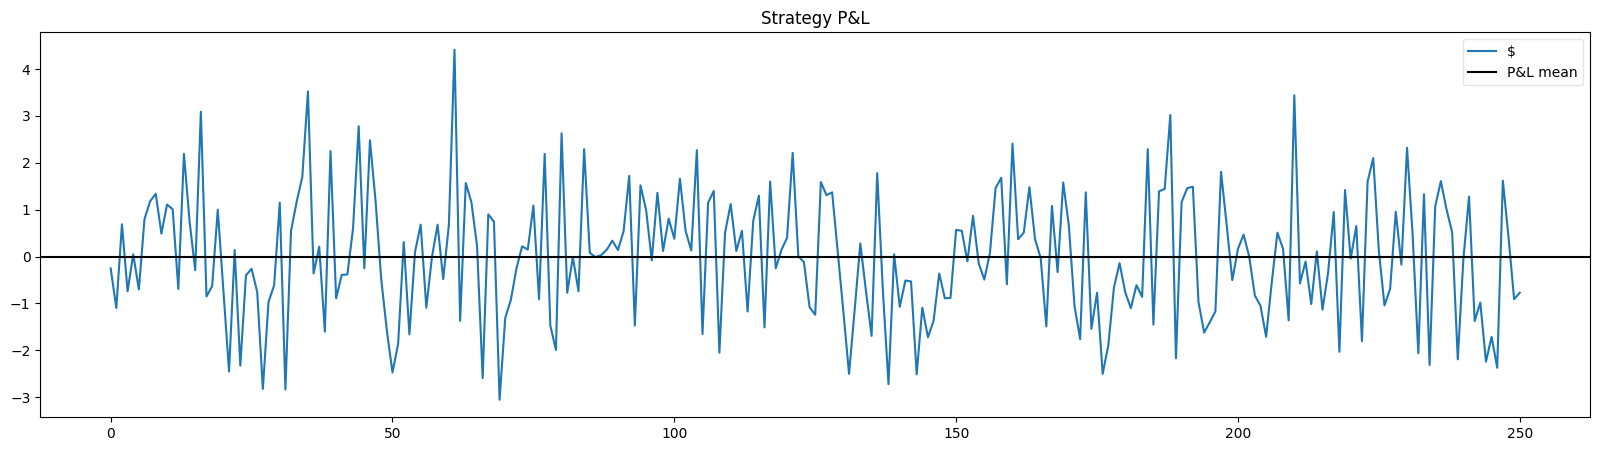

In [4]:
# Change sample to your filename
from arima import getMyPosition as getPosition

# !Do not edit below! #

# Print stats
pll, meanpl, ret, plstd, sharpe, dvol = calcPL(prcAll, getPosition, debug=True)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

# Plot pll
fig = plt.figure(figsize=(20,5))
plt.plot(pll, label='$')
plt.axhline(meanpl, color='black', label='P&L mean')
plt.title('Strategy P&L')
plt.legend(fancybox=True, framealpha=0.5)
plt.show()
plt.close(fig)